## Data

In [36]:
import numpy as np
import pandas as pd
import cvxpy as cp
# cp.__version__

In [2]:
df = pd.read_csv('/content/data.csv')
df.head()

,ticker,date,last,volume
0,1332 JT,2013-01-04,169.0987,1464100
1,1332 JT,2013-01-07,166.3266,1783500
2,1332 JT,2013-01-08,166.3266,1759800
3,1332 JT,2013-01-09,165.4026,767800
4,1332 JT,2013-01-10,167.2507,1503100


In [4]:
df.tail()

,ticker,date,last,volume
451108,9984 JT,2021-03-15,10370.0,12041200
451109,9984 JT,2021-03-16,10620.0,11346000
451110,9984 JT,2021-03-17,10400.0,9771000
451111,9984 JT,2021-03-18,10220.0,13941600
451112,9984 JT,2021-03-19,9969.0,20715700


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451113 entries, 0 to 451112
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ticker  451113 non-null  object 
 1   date    451113 non-null  object 
 2   last    451113 non-null  float64
 3   volume  451113 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 13.8+ MB


In [23]:
# records of some tickers are incomplete

df['ticker'].value_counts()

1332 JT    2005
8053 JT    2005
7011 JT    2005
7012 JT    2005
7013 JT    2005
           ... 
8815 JT     180
8697 JT     157
9434 JT     114
3659 JT      95
3893 JT      55
Name: ticker, Length: 248, dtype: int64

In [33]:
# for simplicity we only consider the assets that are complete
# namey having 2005 records

dfs = pd.DataFrame()
codes = []
for code in df['ticker'].unique():
    cur = df[df['ticker'] == code]
    if len(df[df['ticker'] == code]) == 2005:
        codes.append(code)
        dfs[code] = cur['last'].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


In [34]:
dfs.head()

,1332 JT,1605 JT,1721 JT,1801 JT,1802 JT,1803 JT,1812 JT,1925 JT,1928 JT,1963 JT,...,9502 JT,9503 JT,9531 JT,9532 JT,9602 JT,9613 JT,9735 JT,9766 JT,9983 JT,9984 JT
0,169.0987,970.6780,950.5521,1232.0186,413.2189,278.1162,478.8201,1214.8674,718.0180,2381.3169,...,1038.6998,847.8471,1727.7597,1332.1473,1367.1194,487.5256,3719.2396,1721.7623,20584.8363,1482.3931
1,166.3266,960.1615,924.2187,1236.1949,411.5426,278.1162,480.4769,1196.8868,720.2228,2352.1579,...,1009.8470,804.2336,1744.7820,1327.9713,1364.4123,475.2036,3732.0499,1695.8510,21150.4557,1453.9312
2,166.3266,955.9548,938.6596,1215.3132,407.3517,277.2709,473.8496,1181.2514,709.9339,2378.6661,...,992.8748,795.5109,1761.8042,1340.4993,1377.0457,470.5604,3736.3199,1627.9455,21243.1802,1472.9058
3,165.4026,944.3866,945.4553,1240.3712,417.4098,278.9616,482.1337,1203.1409,707.7291,2395.4546,...,987.7831,780.6823,1766.0598,1336.3233,1440.2130,479.3109,3757.6703,1612.7561,21159.7281,1442.0720
4,167.2507,942.2833,943.7564,1252.9002,435.0114,284.8789,490.4178,1225.8122,727.5720,2398.1054,...,997.9665,810.3395,1757.5487,1340.4993,1516.0136,481.9896,3791.8310,1568.9749,20918.6445,1442.0720


## strategy

We choose 10 with highest returns for simplicity and apply Markowitz theory to construct a portfolio with initial wealth 100.

### choosing assets

In [57]:
# use the first 30% dates to choose assets

start = round(2005*0.3)
dic = {}
assets = []
for code in codes:
    dic[code] = dfs[code].iloc[start] / dfs[code].iloc[0] - 1
total_assets = sorted(dic.items(), key=lambda x:x[1], reverse=True)
for i in range(10):
    ret = total_assets[i][1] / start
    assets.append(total_assets[i][0])
    print('The asset {} has {}-th highest daily yield {:.4}'.format(total_assets[i][0],i+1,ret))

The asset 6479 JT has 1-th highest daily yield 0.01025
The asset 6770 JT has 2-th highest daily yield 0.009722
The asset 2269 JT has 3-th highest daily yield 0.005375
The asset 7270 JT has 4-th highest daily yield 0.005138
The asset 6758 JT has 5-th highest daily yield 0.004743
The asset 4042 JT has 6-th highest daily yield 0.004678
The asset 5332 JT has 7-th highest daily yield 0.004052
The asset 6752 JT has 8-th highest daily yield 0.003756
The asset 6472 JT has 9-th highest daily yield 0.003752
The asset 6762 JT has 10-th highest daily yield 0.003685


### Markowitz

The weights of assets will be altered every 20 days.

In [58]:
df = pd.DataFrame(dfs, columns=assets)

In [59]:
# parameters

bins = 3 
period = 20
factor = 1 
n_days = df.shape[0]
n_assets = df.shape[1]
n_period = n_days // period - bins
capital = 100

In [60]:
n_days = df.shape[0]
n_assets = df.shape[1]
n_period = n_days//period - bins
ws = []
acc_ret = pd.DataFrame()

In [61]:
for i in range(n_period):
    df_prior = df.iloc[i*period:(i+bins)*period,:]
    df_cur = df.iloc[(i+bins)*period:(i+bins+1)*period,:]
    Sigma = df_prior.corr().values
    mu = np.log((df_prior.iloc[-1,:] / df_prior.iloc[0,:]).values)
    w = cp.Variable(n_assets)

    ret = mu.T@w
    risk = cp.quad_form(w, Sigma)
    prob = cp.Problem(cp.Maximize(ret - factor*risk), [cp.sum(w) == 1, w >= 0])
    prob.solve()

    ws.append(w.value)
    acc_ret_cur = pd.DataFrame((w.value * (df_cur / df_cur.iloc[0,:]) * capital).apply(lambda x:x.sum(),axis=1))
    acc_ret = acc_ret.append(acc_ret_cur)

    capital *= np.sum(w.value * (df_cur.iloc[-1,:] / df_cur.iloc[0,:]).values)

In [62]:
# capital of this portfolio, starting from 100

acc_ret

,0
60,100.000000
61,99.813790
62,98.837216
63,102.691287
64,103.939849
...,...
1995,345.277944
1996,345.959753
1997,347.180838
1998,345.891718


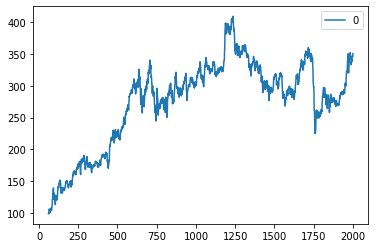

In [56]:
# diagram to show the capital
# indeed it makes profit

acc_ret.plot()

### Summary

This notebook only reveals a simple but common mid-to-low frequncy strategy that maximizes the return and minimizes the risk due to Markowitz theory. A lot of improvements could be made, such as altering the parameters to achieve a higher Sharpe ratio, or choosing different assets to increase the diversification, or setting a lower-bound return and minimizing the risk, etc. It is only to show the efficiency rather than to achieve the highest profit.